# **Capitulo 6 – Ensemble Learning and Random Forests**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/ensembles` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Random Patches and Random Subspaces

La clase BaggingClassifier también admite el muestreo de las features/predictores. El muestreo se controla mediante dos hiperparámetros: max_features y bootstrap_features. 

Funcionan del mismo modo que max_muestras y bootstrap, pero para el muestreo de características en lugar del muestreo de instancias. Así, cada predictor se entrenará con un subconjunto aleatorio de las características de entrada.

Esta técnica es especialmente útil cuando se trabaja con entradas de alta dimensión (como imágenes), ya que puede acelerar considerablemente el entrenamiento. 

El muestreo tanto de las instancias de entrenamiento como de las características se denomina random patches. 

Mantener todas las instancias de entrenamiento (estableciendo bootstrap=False y max_samples=1.0) pero muestrear las características (estableciendo bootstrap_features a True y/o max_features a un valor menor que 1.0) se denomina método de random subpaces.


# Random Forests

Random forest es un conjunto de árboles de decisión, generalmente entrenados mediante el método bagging, normalmente con max_samples fijado al tamaño del conjunto de entrenamiento. 

En lugar de construir un BaggingClassifier y pasarle un DecisionTreeClassifier, puedes usar la clase RandomForestClassifier, que es más conveniente y está optimizada para árboles de decisión (de forma similar, hay una clase RandomForestRegressor para tareas de regresión). 

El siguiente código entrena un clasificador de bosque aleatorio con 500 árboles, cada uno limitado a un máximo de 16 nodos hoja, utilizando todos los núcleos de CPU disponibles:


In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42, max_depth=2)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [13]:
from sklearn.tree import export_graphviz

export_graphviz(
        rnd_clf.estimators_[0],
        out_file=str(IMAGES_PATH / "example_tree.dot"),
        feature_names=["X1", "X2"],
        class_names=["Green", "Blue"],
        rounded=True,
        filled=True
    )

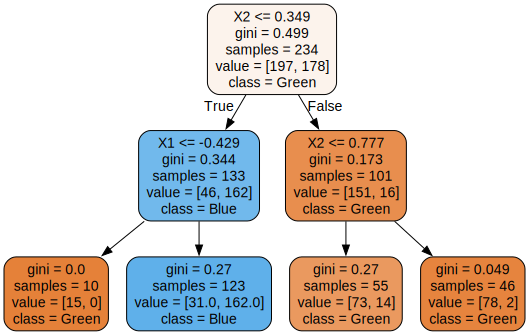

In [14]:
from graphviz import Source

Source.from_file(str(IMAGES_PATH/"example_tree.dot"))

In [17]:
# Calcular accuracy, precision, recall para el random forest
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(accuracy_score(y_train, rnd_clf.predict(X_train)))
print(precision_score(y_train, rnd_clf.predict(X_train)))
print(recall_score(y_train, rnd_clf.predict(X_train)))

0.8906666666666667
0.8918918918918919
0.8870967741935484


In [21]:
# Calcular accuracy, precision, recall para el cada árbol del random forest
a = []
p = []
r = []
for et in rnd_clf.estimators_:
    a.append(accuracy_score(y_train, et.predict(X_train)))
    p.append(precision_score(y_train, et.predict(X_train)))
    r.append(recall_score(y_train, et.predict(X_train)))

In [22]:
print("Max accuracy", max(a))

Max accuracy 0.9013333333333333


In [23]:
print("Max precision", max(p))

Max precision 0.9855072463768116


In [24]:
print("Max recall", max(r))

Max recall 0.9946236559139785


In [ ]:
# Existe algún árbol que tenga más accuracy que el random forest. 

In [26]:
# Replicar el soft voting del random forest
rnd_clf.predict_proba(X_test[:1])

array([[0.48038024, 0.51961976]])

In [28]:
p = []
for et in rnd_clf.estimators_:
    p.append(et.predict_proba(X_test[:1]))

In [29]:
import numpy as np
p = np.array(p)
p.mean(axis=0)

array([[0.48038024, 0.51961976]])

Con algunas excepciones, un RandomForestClassifier tiene todos los hiperparámetros de un DecisionTreeClassifier (max_depth, min_samples_leaf...), además de todos los hiperparámetros de un BaggingClassifier (bootstrap, oob_score) para controlar el conjunto en sí.

El algoritmo de Random Forest introduce una aleatoriedad adicional en el crecimiento de los árboles; en lugar de buscar la mejor característica al dividir un nodo, busca la mejor característica entre un subconjunto aleatorio de características. 

Por defecto, muestrea n características (donde n es el número total de características). El algoritmo da como resultado una mayor diversidad del árbol, que (de nuevo) cambia un mayor bias por una menor variance, lo que generalmente produce un modelo globalmente mejor. 

Así pues, el siguiente BaggingClassifier es equivalente al anterior RandomForestClassifier:

Un Random Forest equivale a un BaggingClassifier:

In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16, max_depth=2),
    n_estimators=500, n_jobs=-1, random_state=42)

In [38]:
import numpy as np
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)


In [39]:
# Todos son iguales
np.all(y_pred_bag == y_pred_rf)

False

In [40]:
# No hay distintos
sum(y_pred_bag != y_pred_rf)

2

In [41]:
# No hay distintos
np.any(y_pred_bag != y_pred_rf)

True

## Extra-Trees

Cuando se hace crecer un árbol en un random forest, en cada nodo sólo se considera un subconjunto aleatorio de las características para la división (como se ha comentado antes). 

Es posible hacer árboles aún más aleatorios utilizando también umbrales aleatorios para cada característica en lugar de buscar los mejores umbrales posibles (como hacen los árboles de decisión normales). Para ello, basta con establecer splitter="random" al crear un DecisionTreeClassifier. 

Splitter puede ser "best" si eliges el mejor corte posible en el nodo o "random" si eliges el mejor corte posible de una muestra aletario.

Un bosque de estos árboles extremadamente aleatorios se denomina conjunto de árboles extremadamente aleatorios (o extra-árboles para abreviar). 

Una vez más, esta técnica cambia un mayor bias por una menor variance. También hace que los clasificadores extra-árboles sean mucho más rápidos de entrenar que los random forest normales, porque encontrar el mejor umbral posible para cada característica en cada nodo es una de las tareas que más tiempo consume en el crecimiento de un árbol. 

Puede crear un clasificador extra-trees utilizando la clase ExtraTreesClassifier de Scikit-Learn. Es idéntica a la de la clase RandomForestClassifier, excepto que el valor predeterminado de bootstrap es False. 

Del mismo modo, la clase ExtraTreesRegressor es similar la clase RandomForestRegressor, excepto que el valor predeterminado de bootstrap es False.


Es difícil saber de antemano si un RandomForestClassifier funcionará mejor o peor que un ExtraTreesClassifier. Por lo general, la única forma de saberlo es probar ambos y compararlos mediante cross validation.

In [42]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=1, splitter="best", random_state=42)
tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=1, random_state=42)

In [43]:
export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "example_tree_2.dot"),
        feature_names=["X1", "X2"],
        class_names=["Green", "Blue"],
        rounded=True,
        filled=True
    )

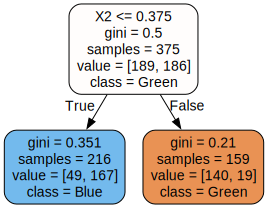

In [44]:
from graphviz import Source

Source.from_file(str(IMAGES_PATH/"example_tree_2.dot"))

In [ ]:
# No podemos encontrar ningún corte en X2 cuyo gini sea menor que la media ponderada de las hojas
# Vamos a comprobarlo

In [45]:
import pandas as pd
dt = pd.DataFrame(X_train)
dt.columns = ["X1", "X2"]

In [46]:
dt["label_real"] = y_train

In [49]:
dt[dt["X2"]<=0.370]["label_real"].value_counts(normalize=True)

label_real
1    0.771028
0    0.228972
Name: proportion, dtype: float64

In [50]:
dt

,X1,X2,label_real
0,1.538699,0.188744,1
1,0.394699,0.323724,0
2,-0.919147,1.311882,0
3,1.053964,-0.700408,1
4,1.040678,-0.437339,1
...,...,...,...
370,0.435785,-0.186108,1
371,-0.565615,0.563578,0
372,-1.205374,1.285517,0
373,0.515727,-0.347822,1


In [51]:
G1 = 1 - ( 0.771028)**2 - (0.228972)**2
print(G1)

0.35308764643199986


In [52]:
dt[dt["X2"]>0.370]["label_real"].value_counts(normalize=True)

label_real
0    0.869565
1    0.130435
Name: proportion, dtype: float64

In [53]:
G2 = 1 - (0.869565)**2 - (0.130435)**2
print(G2)

0.22684342154999992


In [54]:
G_alternativo = G1*len(dt[dt["X2"]<=0.370])/len(dt) + G2*len(dt[dt["X2"]>0.370])/len(dt) 
print(G_alternativo)

0.2988867925493279


In [55]:
G_original = 0.351*216/375 + 0.21*159/375
print(G_original)

0.29121600000000003


In [59]:
# Hacerlo para todos los posibles cortes de X2
# Sin hardcodear
# Usar funciones
def gini(p):
    gini = 1 - (p)**2 - (1-p)**2
    return gini

In [61]:
print(gini(0.771028))

0.3530876464319999


In [64]:
def calcula_hojas(dt, columna):
    resultado = dt[dt[columna]>0.370]['label_real'].value_counts(normalize=True)
    return resultado

In [65]:
print(calcula_hojas(dt, 'X2'))

label_real
0    0.869565
1    0.130435
Name: proportion, dtype: float64


In [66]:
def gini_ponderado(g, p):
    g_p = g[0]*p + g[1]*(1-p)
    return g_p

In [67]:
ginis = (0.351, 0.21)
gini_ponderado(ginis, 216/375)

0.291216

In [57]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
ext_clf.fit(X_train, y_train)
y_pred_ext = ext_clf.predict(X_test)

In [93]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_ext)

0.912

In [94]:
accuracy_score(y_test, y_pred_rf)

0.912

In [ ]:
# Comprobar precision y recall

In [ ]:
# Repetir el ejercicio de replicar el voting

In [ ]:
# Aumentar el n_estimators para ambos. Analizar tiempo

## Feature Importance

Otra gran cualidad de los Random Forest es que facilitan la medición de la importancia relativa de cada característica. 

Scikit-Learn mide la importancia de una característica observando en qué medida los nodos del árbol que utilizan esa característica reducen la impureza de media, en todos los árboles del bosque. Más concretamente, se trata de una media ponderada, en la que el peso de cada nodo es igual al número de muestras de entrenamiento asociadas a él.

Scikit-Learn calcula esta puntuación automáticamente para cada característica después del entrenamiento, y luego escala los resultados para que la suma de todas las importancias sea igual a 1. 

POdemos acceder al resultado utilizando la variable feature_importances_. Por ejemplo, el siguiente código entrena un RandomForestClassifier en el conjunto de datos del iris y muestra la importancia de cada característica. Parece que las características más importantes son la longitud (44%) y la anchura (42%) de los pétalos, mientras que la longitud y la anchura de los sépalos son poco importantes en comparación (11% y 2%, respectivamente):

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

Del mismo modo, si se entrena un clasificador de random forest en el conjunto de datos MNIST y se representa gráficamente la importancia de cada píxel, se obtiene la imagen representada en la Figura.

In [ ]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

Los random forest son muy útiles para comprender rápidamente qué características son realmente importantes, en particular si necesita realizar una selección de características.